In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "" # Delete above if you want to use GPU
import tensorflow as tf
import keras
from keras.layers import Softmax,Input,TimeDistributed,Dense,Average,GlobalAveragePooling1D,Concatenate,Lambda,RepeatVector
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
import tensorflow_probability as tfp
html_width(HTML("<style>.container { width:90% !important; }</style>"))
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy.interpolate import UnivariateSpline


/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

#### The LfD part of the code is taken from https://github.com/rssCNMP/CNMP

## Creating dataset
* Here 30 demonstrations are collected for random 30 environments (Y)
* Task parameters are coordinates of hole and goal points in 2d space(y_parameter)

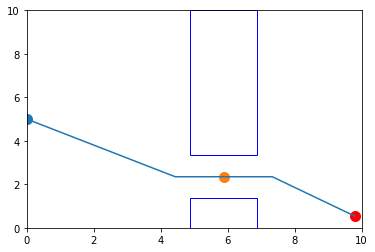

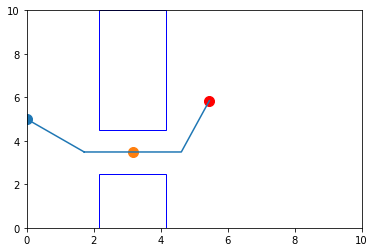

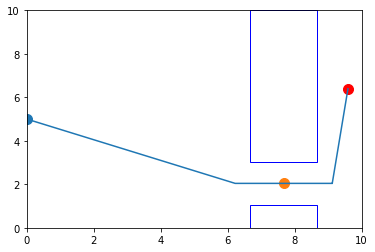

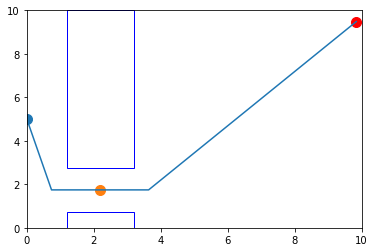

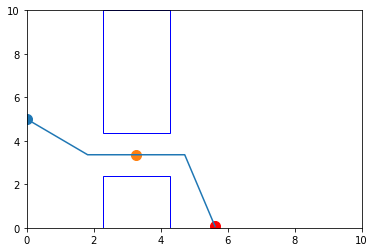

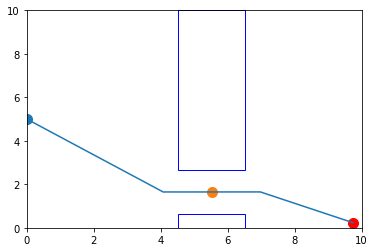

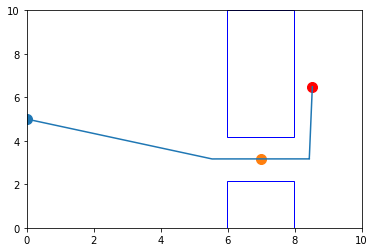

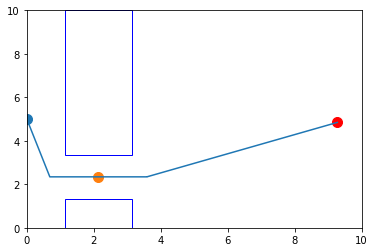

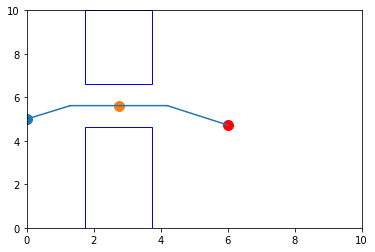

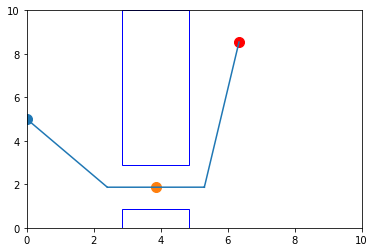

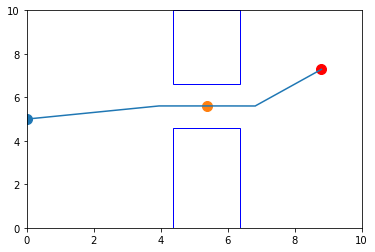

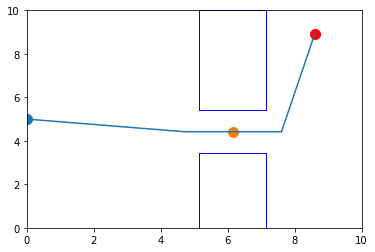

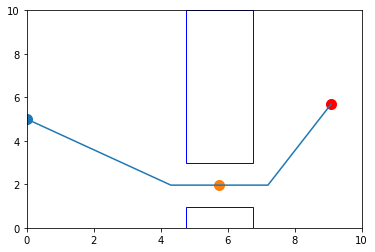

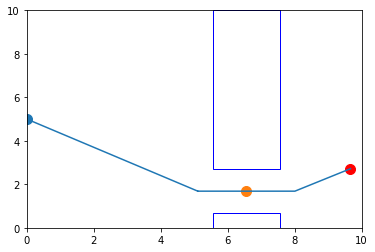

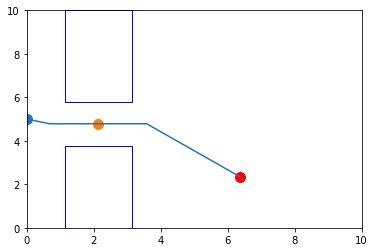

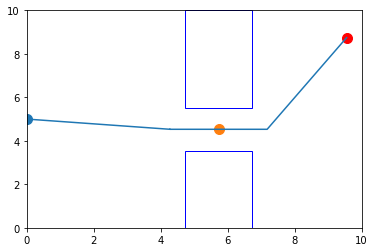

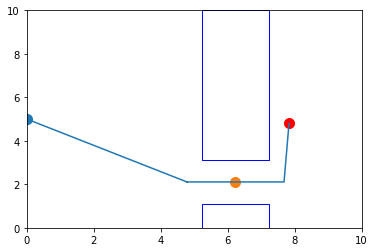

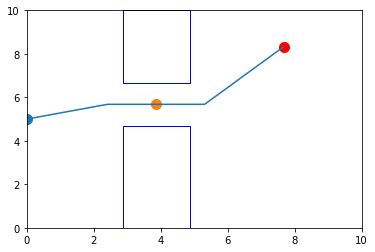

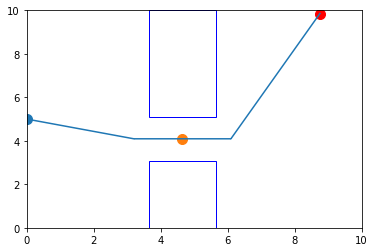

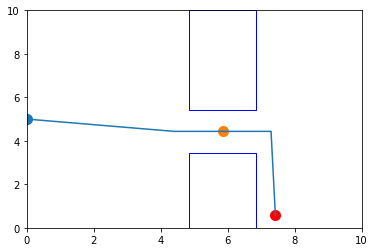

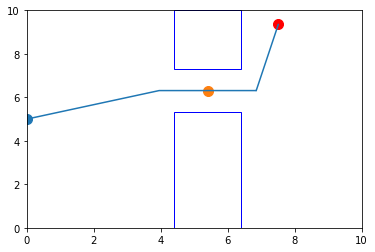

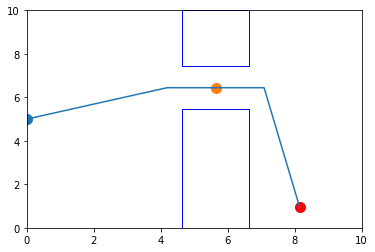

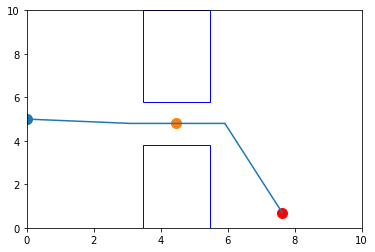

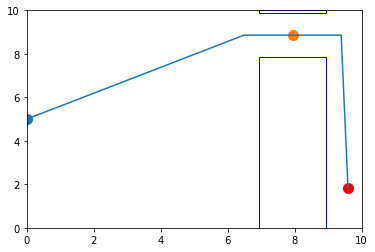

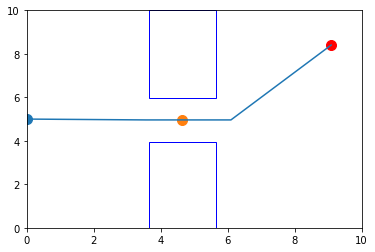

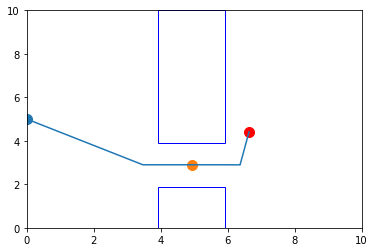

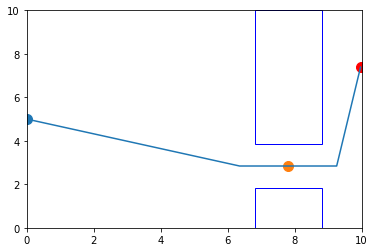

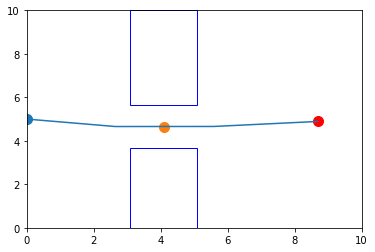

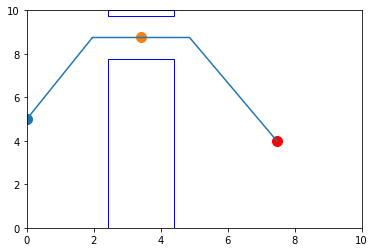

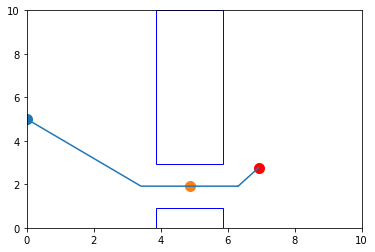

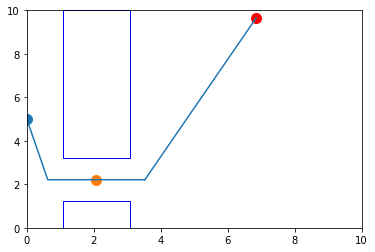

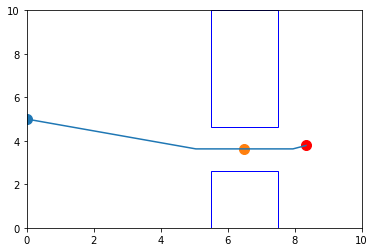

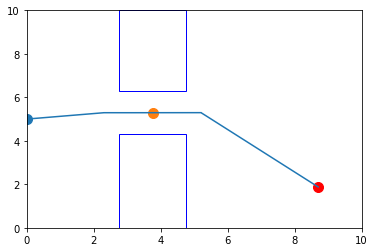

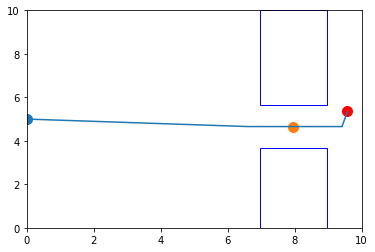

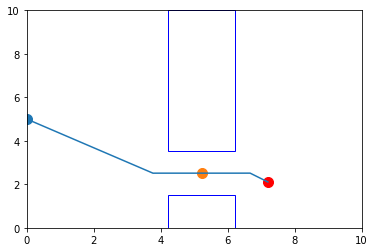

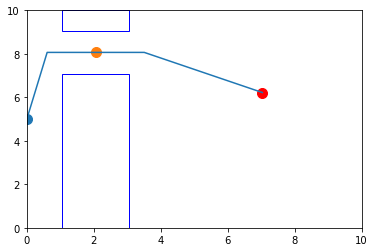

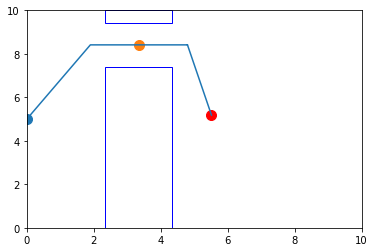

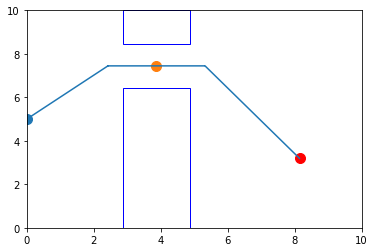

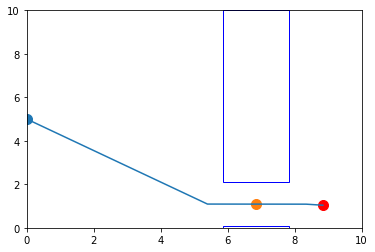

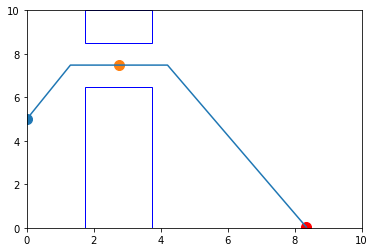

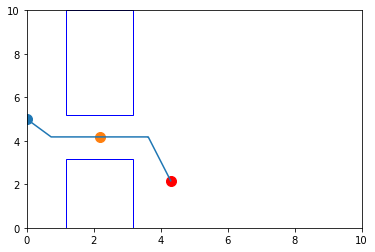

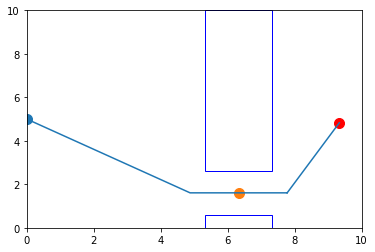

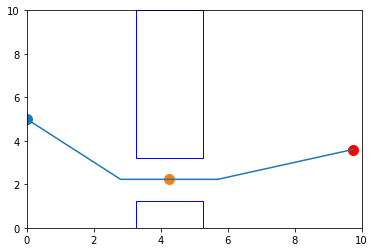

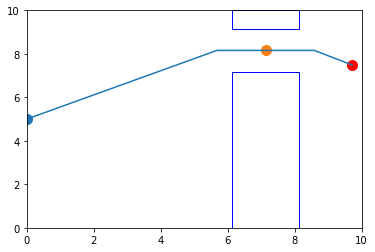

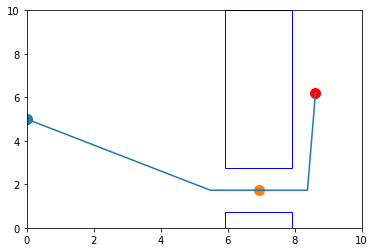

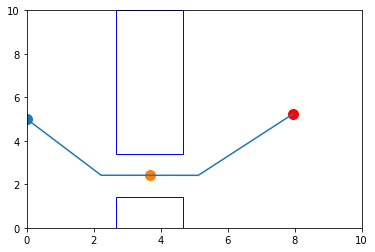

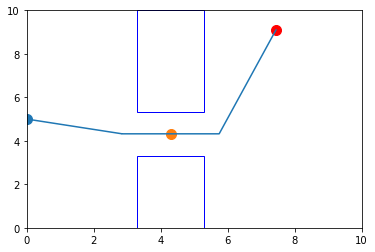

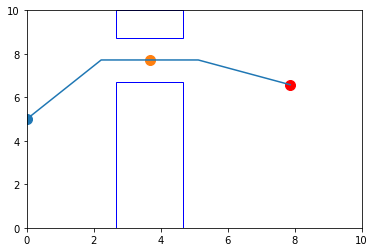

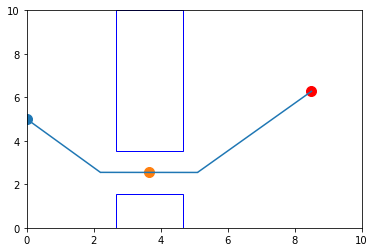

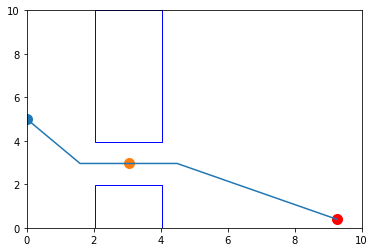

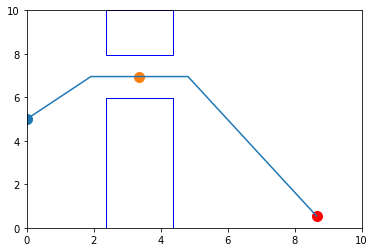

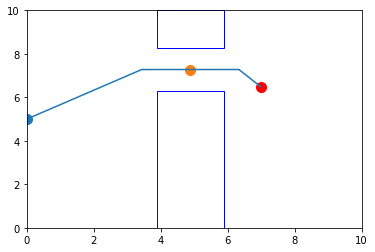

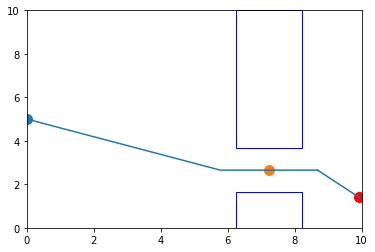

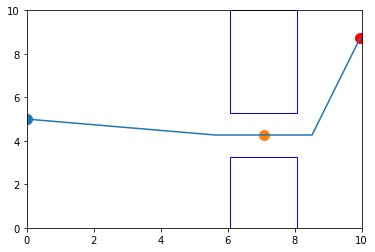

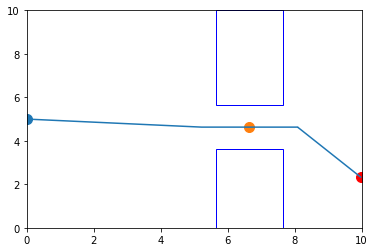

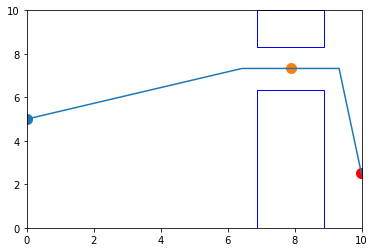

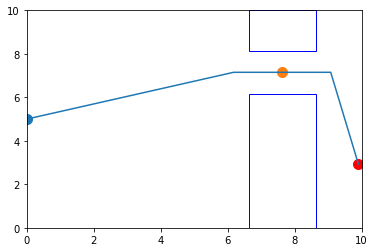

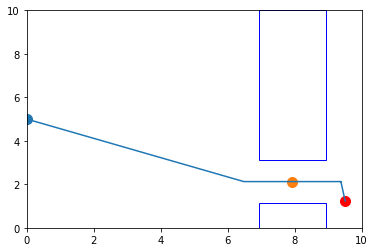

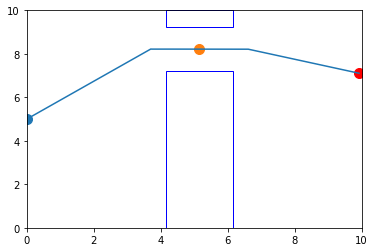

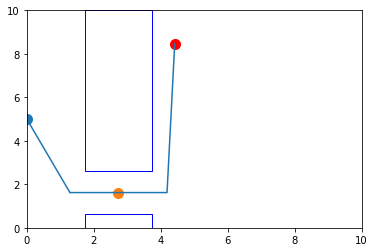

In [2]:
Y=np.zeros((30,200,2))
v_Y=np.zeros((30,200,2))
y_parameter=np.zeros((30,4))
v_y_parameter=np.zeros((30,4))
for k in range(60):
    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    hole_x = np.random.uniform(2,8)
    hole_y = np.random.uniform(1,9)
    goal_x = np.random.uniform(hole_x+1.5,10)
    goal_y = np.random.uniform(0,10)
    s_h_x=hole_x-1.45
    e_h_x=hole_x+1.45
    start_x = 0.0
    start_y = 5.0
    #print(hole_x,hole_y,goal_x,goal_y)
    plt.scatter(start_x,start_y,s=100)
    plt.scatter(hole_x,hole_y,s=100)
    #plt.scatter(s_h_x,hole_y,s=5)
    #plt.scatter(e_h_x,hole_y,s=5)
    plt.scatter(goal_x,goal_y,c='red',s=100)
    plt.xlim((0,10))
    plt.ylim((0,10))
    ax.add_patch( Rectangle((hole_x-1, 0), 
                            2, hole_y-1, 
                            fc ='none',  
                            ec ='b', 
                            lw = 1) ) 

    ax.add_patch( Rectangle((hole_x-1, hole_y+1), 
                            2, 9-hole_y, 
                            fc ='none',  
                            ec ='b', 
                            lw = 1) ) 


    #end_of_scene

    l1= np.sqrt(np.square(s_h_x-0)+np.square(hole_y-5))
    l2= 2.0
    l3= np.sqrt(np.square(e_h_x-goal_x)+np.square(goal_y-hole_y))
    sum_l=l1+l2+l3
    dur1=int(np.round(200*l1/sum_l))
    dur2=int(np.round(200*l2/sum_l))
    dur3=int(np.round(200*l3/sum_l))
    #print(dur1,dur2,dur3)

    traj_x1 = np.linspace(0,s_h_x,dur1)
    traj_y1 = np.linspace(5,hole_y,dur1)
    traj_x2 = np.linspace(s_h_x,e_h_x,dur2)
    traj_y2 = np.linspace(hole_y,hole_y,dur2)
    traj_x3 = np.linspace(e_h_x,goal_x,dur3)
    traj_y3 = np.linspace(hole_y,goal_y,dur3)
    traj_x = np.concatenate((traj_x1,traj_x2,traj_x3))
    traj_y = np.concatenate((traj_y1,traj_y2,traj_y3))

    temp_y=np.zeros((200,2))

    for j in range (2):
        if j==0:
            old_indices = np.arange(0,len(traj_x))
            new_length = 200
            new_indices = np.linspace(0,len(traj_x)-1,new_length)
            spl = UnivariateSpline(old_indices,traj_x,k=3,s=0.000)
            temp_y[:,j] = spl(new_indices)
        else:
            old_indices = np.arange(0,len(traj_y))
            new_length = 200
            new_indices = np.linspace(0,len(traj_y)-1,new_length)
            spl = UnivariateSpline(old_indices,traj_y,k=3,s=0.000)
            temp_y[:,j] = spl(new_indices)

    ax.plot(temp_y[:,0],temp_y[:,1])
    plt.show()
    #fig.clear()    
    if k<30:
        Y[k]=temp_y
        y_parameter[k]=[hole_x/10,hole_y/10,goal_x/10,goal_y/10]
    else:
        v_Y[k-30]=temp_y
        v_y_parameter[k-30]=[hole_x/10,hole_y/10,goal_x/10,goal_y/10]

## Training and validation trajectories are plotted 

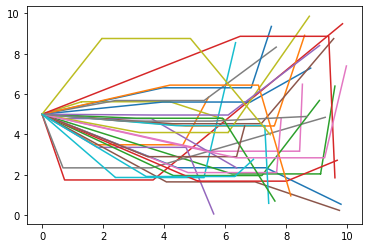

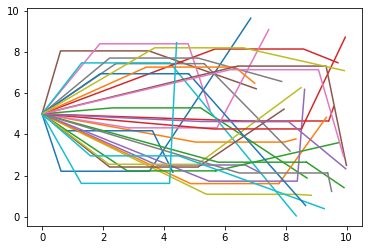

In [3]:
time_N = 200
times = np.linspace(0,1,time_N)
data_size=30
val_size=30
n_max=5
for p in range(data_size):
        plt.plot(Y[p,:,0], Y[p,:,1])
plt.show()        
for p in range(val_size):
        plt.plot(v_Y[p,:,0], v_Y[p,:,1])
plt.show() 

* <b>obs_max</b>: Hyperparameter that decides to the maximum number of observations CNMP uses. In this experiment, it is set to 5
    
* <b>d_N</b>: Number of demonstrations

* <b>d_x</b>: X vector feature dim (NOTE THAT: external parameters are inside of the X vector, concatenated to time value. )

* <b>d_y</b>: Y vector feature dim

* <b>time_len</b>: length of the demonstrations, if all demonstrations does not have same length, use array and edit methods using time_len, or preprocess your data to interpolate into same time length (check numpy.interp)

* <b>X</b>: shape=(d_N,time_len,d_x) --- time (and external parameter) values for each timestep for ith demonstration. d_x = 1+d_external_parameters

* <b>obs_mlp_layers</b>: Hidden neuron numbers of the dense layers inside of the Observation multi layer perceptron. Layer numbers can adapt to the list size. Last layer is always Linear, others are ReLU activated.

* <b>decoder_layers</b>: Hidden neuron numbers of the dense layers inside of the Decoder multi layer perceptron. Layer numbers can adapt to the list size. Last layer size is always 2*d_y and activation is Linear, others are ReLU activated.

In [4]:
X = np.zeros((data_size,time_N,5))

for i in range(data_size):
    for j in range(time_N):
        X[i,j,0]=times[j]
        X[i,j,1]=y_parameter[i,0]
        X[i,j,2]=y_parameter[i,1]
        X[i,j,3]=y_parameter[i,2]
        X[i,j,4]=y_parameter[i,3]
        
v_X = np.zeros((val_size,time_N,5))

for i in range(val_size):
    for j in range(time_N):
        v_X[i,j,0]=times[j]
        v_X[i,j,1]=v_y_parameter[i,0]
        v_X[i,j,2]=v_y_parameter[i,1]
        v_X[i,j,3]=v_y_parameter[i,2]
        v_X[i,j,4]=v_y_parameter[i,3]

obs_max = 5 
d_N = X.shape[0] 
d_x , d_y = (X.shape[-1] , Y.shape[-1])
time_len = X.shape[1] 
obs_mlp_layers = [128,128,128,128,128,128,64]
decoder_layers = [128,128,128,128,128,64,32,d_y*2]

print ('d_N=', d_N)
print ('obs_max=', obs_max)
print ('X',X.shape,', Y',Y.shape)
print ('d_x=',d_x)
print ('d_y=',d_y)
print ('time_len=', time_len )

d_N= 30
obs_max= 5
X (30, 200, 5) , Y (30, 200, 2)
d_x= 5
d_y= 2
time_len= 200


In [5]:
def get_train_sample():
    n = np.random.randint(0,obs_max)+1
    d = np.random.randint(0, d_N)
    observation = np.zeros((1,n,d_x+d_y)) 
    target_X = np.zeros((1,1,d_x))
    target_Y = np.zeros((1,1,d_y*2))
    perm = np.random.permutation(time_len)
    observation[0,:n,:d_x] = X[d,perm[:n]]
    observation[0,:n,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0,0] = X[d,perm[n]]
    target_Y[0,0,:d_y] = Y[d,perm[n]]
    return [observation,target_X], target_Y

In [6]:
def predict_model(observation, target_X, plot = True):
    predicted_Y = np.zeros((time_len,d_y))
    predicted_std = np.zeros((time_len,d_y))
    prediction = model.predict([observation,target_X])[0] 
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        for i in range(d_y): #for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            for j in range(d_N):
                plt.plot(X[j,:,0],Y[j,:,i]) # assuming X[j,:,0] is time
            plt.plot(X[j,:,0],predicted_Y[:,i],color='black')
            plt.errorbar(X[j,:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.4)
            plt.scatter(observation[0,:,0],observation[0,:,d_x+i],marker="X",color='black')
            plt.show()  
    return predicted_Y, predicted_std

In [7]:
def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, temp =tf.split(y_true,2,axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss

In [8]:
def MLP(input_dim, layers, name="mlp", parallel_inputs=False):
    input_layer = Input(shape=(None, input_dim),name=name+'_input')
    for i in range(len(layers)-1):
        hidden = TimeDistributed(Dense(layers[i], activation='relu'), name=name+'_'+str(i))(input_layer if i == 0 else hidden) if parallel_inputs else Dense(layers[i], activation='relu', name=name+'_'+str(i))(input_layer if i == 0 else hidden)
    hidden = TimeDistributed(Dense(layers[-1]), name=name+'_output')(hidden) if parallel_inputs else Dense(layers[-1], name=name+'_output')(hidden)
    return Model(input_layer, hidden, name=name)

## LfD Model





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation (InputLayer)        (None, None, 7)      0                                            
__________________________________________________________________________________________________
obs_mlp (Model)                 (None, None, 64)     91840       observation[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 64)           0           obs_mlp[1][0]                    
__________________________________________________________________________________________________
target (InputLayer)             (None, None, 5)      0                                            
________________________________________________________________________________________

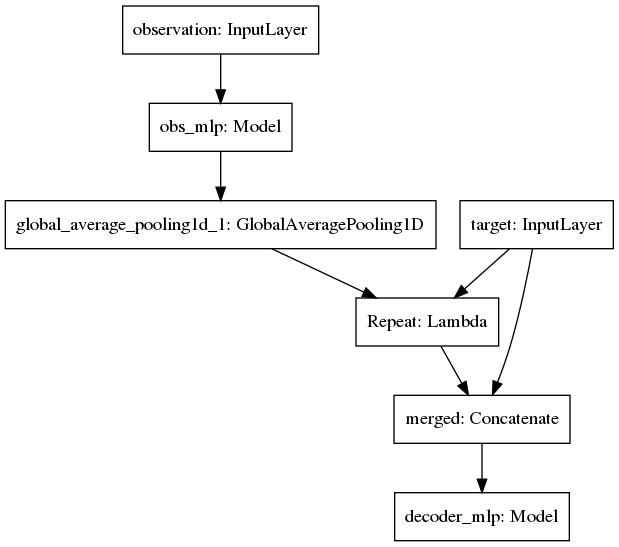

In [9]:
observation_layer = Input(shape=(None,d_x+d_y), name="observation") # (x_o,y_o) tuples
target_X_layer = Input(shape=(None,d_x), name="target") # x_q

ObsMLP = MLP(d_x+d_y, obs_mlp_layers, name='obs_mlp', parallel_inputs=True) # Network E
obs_representations = ObsMLP(observation_layer) # r_i
general_representation = GlobalAveragePooling1D()(obs_representations) # r
general_representation = Lambda(lambda x: tf.keras.backend.repeat(x[0],tf.shape(x[1])[1]), name='Repeat')([general_representation,target_X_layer]) # r in batch form (same)

merged_layer = Concatenate(axis=2, name='merged')([general_representation,target_X_layer]) # (r,x_q) tuple
Decoder = MLP(d_x+obs_mlp_layers[-1], decoder_layers, name = 'decoder_mlp', parallel_inputs=False) # Network Q
output = Decoder(merged_layer) # (mean_q, std_q)

model = Model([observation_layer, target_X_layer],output)
model.compile(optimizer = Adam(lr = 1e-4),loss=custom_loss)
model.summary()

plot_model(model)

## RL model

In [10]:
import keras.backend as K
def custom_loss2(taken, predicted):
    predicted_action_mean, predicted_action_sigma = tf.split(predicted, 2, axis=-1)
    taken_action, q_value =tf.split(taken,2,axis=-1)
    #q1,_,_,_,_,_ = tf.split(q_value,6,axis=-1)
    #sigma = tf.nn.softplus(predicted_action_sigma)
    square_loss=tf.math.square(taken_action-predicted_action_mean)
    loss=(1./4.)*tf.math.multiply(square_loss,q_value)
    print(np.shape(loss))
    return K.mean(loss)

(?, ?, 2)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation (InputLayer)        (None, None, 7)      0                                            
__________________________________________________________________________________________________
obs_mlp (Model)                 (None, None, 64)     91840       observation[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 64)           0           obs_mlp[1][0]                    
__________________________________________________________________________________________________
target (InputLayer)             (None, None, 5)      0                                            
__________________________________________________________________________________

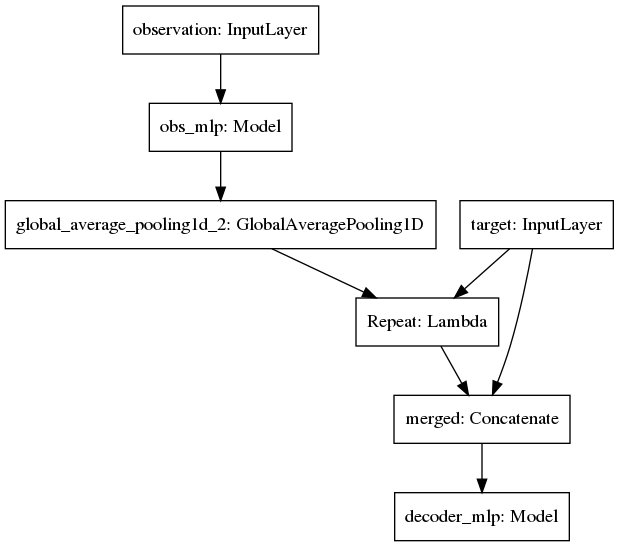

In [11]:
observation_layer = Input(shape=(None,d_x+d_y), name="observation") # (x_o,y_o) tuples
target_X_layer = Input(shape=(None,d_x), name="target") # x_q

ObsMLP = MLP(d_x+d_y, obs_mlp_layers, name='obs_mlp', parallel_inputs=True) # Network E
obs_representations = ObsMLP(observation_layer) # r_i
general_representation = GlobalAveragePooling1D()(obs_representations) # r
general_representation = Lambda(lambda x: tf.keras.backend.repeat(x[0],tf.shape(x[1])[1]), name='Repeat')([general_representation,target_X_layer]) # r in batch form (same)

merged_layer = Concatenate(axis=2, name='merged')([general_representation,target_X_layer]) # (r,x_q) tuple
Decoder = MLP(d_x+obs_mlp_layers[-1], decoder_layers, name = 'decoder_mlp', parallel_inputs=False) # Network Q
output = Decoder(merged_layer) # (mean_q, std_q)

model2 = Model([observation_layer, target_X_layer],output)
model2.compile(optimizer = Adam(lr = 1e-4),loss=custom_loss2)
model2.summary()

plot_model(model2)

In [12]:
def generator():
    while True:
        inp,out = get_train_sample()
        yield (inp, out)

In [13]:
valll_error = 99999999

In [14]:
class CNMP_Callback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.smooth_losses = [0]
        self.losses = []
        self.step = 0
        self.loss_checkpoint = 1000
        self.plot_checkpoint = 10000
        self.validation_checkpoint = 100
        self.validation_error = valll_error
        return

    def on_batch_end(self, batch, logs={}):
        
        if self.step % 4000 == 0:
            print('Val_Error is :',self.validation_error)
        
        if self.step % self.validation_checkpoint == 0:
            ### Here, you should customize our own validation function according to your data and save your best model ###
            current_error = 0
            for i in range(v_X.shape[0]):
                # predicting whole trajectory by using the first time step of the ith validation trajectory as given observation
                predicted_Y,predicted_std = predict_model(np.concatenate((v_X[i,-1],v_Y[i,-1])).reshape(1,1,d_x+d_y), v_X[i].reshape(1,time_len,d_x), plot= False)
                #current_error += np.mean((predicted_Y[0] - v_Y[i,0])**2)# / v_X.shape[0]
                current_error += np.mean((predicted_Y[-1] - v_Y[i,-1])**2)# / v_X.shape[0]
            if current_error < self.validation_error:
                self.validation_error = current_error
                valll_error = current_error
                model.save('cnmp_best_validation_third_experiment.h5')
                print (' New validation best. Error is ', current_error)
            ### If you are not using validation, please note that every large-enough nn model will eventually overfit to the input data ###
            
        if self.step % self.loss_checkpoint == 0:
            self.losses.append(logs.get('loss'))
            self.smooth_losses[-1] += logs.get('loss')/(self.plot_checkpoint/self.loss_checkpoint)
            
        if self.step % self.plot_checkpoint == 0:
            print (self.step)
            #clearing output cell
            display.clear_output(wait=True)
            display.display(pl.gcf())
            
            #plotting training and smoothed losses
            plt.figure(figsize=(15,5))
            plt.subplot(121)
            plt.title('Train Loss')
            plt.plot(range(len(self.losses)),self.losses)
            plt.subplot(122)
            plt.title('Train Loss (Smoothed)')
            plt.plot(range(len(self.smooth_losses)),self.smooth_losses)
            plt.show()
            
            #plotting on-train examples by user given observations
            for i in range(2):
                #for each validation trajectory, predicting and plotting whole trajectories by using the first time steps as given observations. 
                predict_model(np.concatenate((v_X[i,0],v_Y[i,0])).reshape(1,1,d_x+d_y), v_X[i].reshape(1,time_len,d_x))
            
            if self.step!=0:
                self.smooth_losses.append(0)
            
        self.step += 1
        return

## You can skip to the animation part at the end for trained model's result

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

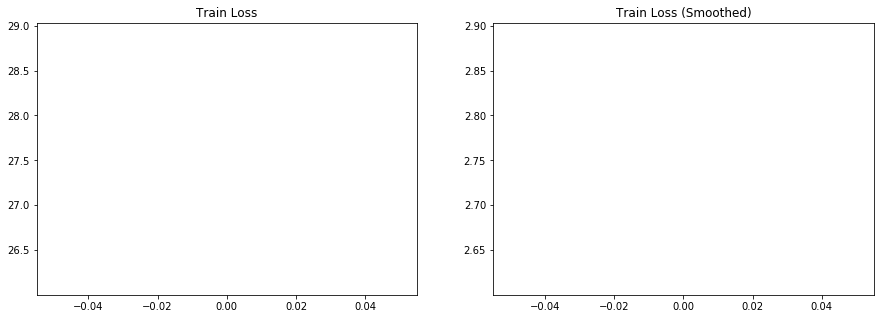

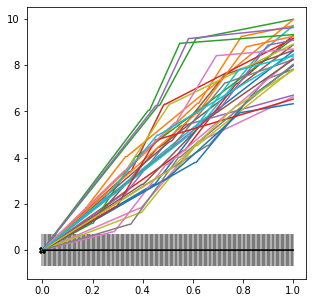

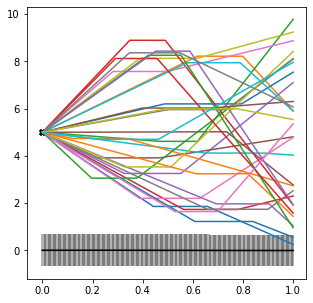

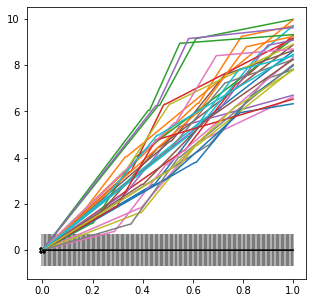

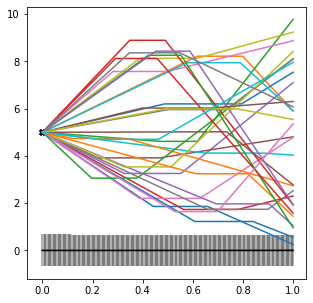

     82/1000000 [..............................] - ETA: 6:35:10 - loss: 45.5649

/home/tuluhan/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.006783). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tuluhan/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.503635). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


   2970/1000000 [..............................] - ETA: 43:43 - loss: 5.6508

KeyboardInterrupt: 

In [16]:
max_training_step = 1000000
model.fit_generator(generator(), steps_per_epoch=max_training_step, epochs=1, verbose=1, callbacks=[CNMP_Callback()])


In [18]:
import keras.losses
keras.losses.custom_loss = custom_loss
model = load_model('cnmp_best_validation_third_experiment.h5', custom_objects={ 'tf':tf })

In [19]:
def normpdf(x, mean, sd):
    denom = sd*(2*math.pi)**0.5
    num= math.exp(-0.5*((x-mean)/float(sd))**2)
    return num/denom

In [20]:
def KL_divergence_func(actions1,actions2):
    error=0
    for i in range(time_N):
        error2=np.square(actions1[i]-actions2[i])
        error=max(error,error2)
    return error

### Plotting the environment

In [22]:
def plot_figure(start_x,start_y,hole_x,hole_y,goal_x,goal_y,predicted_Y):
    fig = plt.figure() 
    ax = fig.add_subplot(111)
    plt.scatter(start_x,start_y,s=100)
    plt.scatter(hole_x,hole_y,s=100)
    plt.scatter(goal_x,goal_y,c='red',s=100)
    plt.xlim((0,10))
    plt.ylim((0,10))
    ax.add_patch( Rectangle((hole_x-1, 0), 
                        2, hole_y-1, 
                        fc ='none',  
                        ec ='b', 
                        lw = 1) ) 

    ax.add_patch( Rectangle((hole_x-1, hole_y+1), 
                        2, 9-hole_y, 
                        fc ='none',  
                        ec ='b', 
                        lw = 1) ) 

    ax.plot(predicted_Y[:,0],predicted_Y[:,1])
    plt.show()

### Reinforcement learning function similar to other experiments

In [23]:
def rl_agent(cx1,cy1,cx2,cy2,cx3,cy3,states1,states2,states,max_reward): 
    
    #predicted_Y = np.zeros((200,2))
    for i in range(50):
        inp,out = get_train_sample()
        out[0][0][2]=1
        out[0][0][3]=1
        data = model2.fit(inp,out,batch_size=1,verbose=0)
        
    model_reward=0
    
    dist2=10000
    
    for i in range(time_N):
        pred= model2.predict([[states1[i]],[states2[i]]])[0][0]
        if (pred[0]>cx2-1) and (pred[0]<cx2+1):
            temp2=min(np.square(pred[1]-(cy2-1)),np.square(pred[1]-(cy2+1)))
            if (pred[1] > (cy2+1)) or (pred[1] < (cy2-1)):
                temp2 = temp2 * (-1)
        else:
            continue
            
        if(temp2<dist2):
            dist2 = temp2
            closest_time = i
        #predicted_Y[i]=pred[:d_y]

    #plot_figure(cx1,cy1,cx2,cy2,cx3,cy3,predicted_Y)
    
    actions, rewards,rewards2 = [], [], []
    action_prob,actions_mean = [], []
    for i in range(time_N):
        pred= model2.predict([[states1[i]],[states2[i]]])[0][0]
        selected_action = [np.random.normal(pred[0], 0.1, 1)[0], np.random.normal(pred[1], 0.1, 1)[0]]
        action_prob.append([normpdf(selected_action[0], pred[0], 0.1),normpdf(selected_action[1], pred[1], 0.1)])
        actions.append(selected_action)
        actions_mean.append(pred[:d_y])
        reward = 0
        reward2= 0
        
        if i == 0:
            reward +=  -np.sqrt(np.square(selected_action[0]-cx1)+ np.square(selected_action[1]-cy1))
            reward2 += -np.sqrt(np.square(pred[0]-cx1)+ np.square(pred[1]-cy1))
        elif i == closest_time:
            
            r1=min(np.square(selected_action[1]-(cy2-1)),np.square(selected_action[1]-(cy2+1)))
            if (selected_action[1] > (cy2+1)) or (selected_action[1] < (cy2-1)):
                r1 = r1 * (-1)
            
            r2=min(np.square(pred[1]-(cy2-1)),np.square(pred[1]-(cy2+1)))
            if (pred[1] > (cy2+1)) or (pred[1] < (cy2-1)):
                r2 = r2 * (-1)
                
            reward +=  r1
            reward2 += r2
            
        elif i == time_N-1:
            reward +=  -2*np.sqrt(np.square(selected_action[0]-cx3)+ np.square(selected_action[1]-cy3))
            reward2 += -2*np.sqrt(np.square(pred[0]-cx3)+ np.square(pred[1]-cy3))
        else:
            reward+=0
            reward2+=0
            
        rewards.append(reward)
        rewards2.append(reward2)
        
    sum_rewards = np.sum(rewards2)
    print(sum_rewards)
    if(np.absolute(rewards2[0])<0.05) and (np.absolute(rewards2[time_N-1])<0.1):
        if (r2 >0.4):
            flag=1
            return flag
    
    discounted_rewards=rewards
    discounted_rewards2=rewards2
    for i in range(time_N):
        discounted_rewards[i]=discounted_rewards[i]-discounted_rewards2[i]
    #discounted_rewards -= np.mean(discounted_rewards)
    discounted_rewards /= np.std(discounted_rewards)
    
    yeni_rewards=discounted_rewards
    advantages=np.zeros((time_N,1,4))
    for i in range(time_N):
        for j in range(2):
            advantages[i][0][j]=actions[i][j]
            advantages[i][0][j+2]=discounted_rewards[i]
    data = model2.fit(states,advantages,verbose=0)
    counter=0
    while(1):
        counter+=1
        actions2=[]
        action_prob2=[]
        
        for i in range(20):
            inp,out = get_train_sample()
            out[0][0][2]=1
            out[0][0][3]=1
            data = model2.fit(inp,out,batch_size=1,verbose=0)
            
        for i in range(time_N):
            pred= model2.predict([[states1[i]],[states2[i]]])[0][0]
            selected_action = actions[i]
            selected_action2 = [np.random.normal(pred[0], 0.1, 1)[0], np.random.normal(pred[1], 0.1, 1)[0]]
            action_prob2.append([normpdf(selected_action[0], pred[0], 0.1),normpdf(selected_action[1], pred[1], 0.1)])
            actions2.append(pred[:d_y])
        advantages2=np.zeros((time_N,1,4))
        for i in range(time_N):
            for j in range(2):
                advantages2[i][0][j]=actions[i][j]
                advantages2[i][0][j+2]=discounted_rewards[i]*min(1,(action_prob2[i][j]/action_prob[i][j]))
        act1=np.transpose(actions_mean)
        act2=np.transpose(actions2)
        
        KL_diff1=KL_divergence_func(act1[0],act2[0])
        KL_diff2=KL_divergence_func(act1[1],act2[1])
        KL_diff=max(KL_diff1,KL_diff2)
        if KL_diff>0.07:
            break
        elif counter>50:
            break
        else:
            #print("offpolicy")
            data = model2.fit(states,advantages2,verbose=0)
        
    flag=0
    return flag

### RL learning function to form states and keep track of learning through plots

In [34]:
def rl_learning(new_observation,states2,hole_x,hole_y,goal_x,goal_y,new_X):

    model2.load_weights('cnmp_best_validation_third_experiment.h5')
    for i in range(time_N):
        if(i==0):
            states1=new_observation
            
        else:
            states1=np.concatenate((states1,new_observation),axis=0)
            
    states=[states1,states2]
    max_reward=-100.0
    for i in range(1000):
        flag = rl_agent(0,5,hole_x,hole_y,goal_x,goal_y,states1,states2,states,max_reward)
        
        if i %20 == 0:
            display.clear_output(wait=True)
            display.display(pl.gcf())
            prediction = model2.predict([new_observation,new_X])[0]
            predicted_Y = prediction[:,:d_y]
            plot_figure(0,5,hole_x,hole_y,goal_x,goal_y,predicted_Y)
            print(i)
            
        
        if flag == 1:
            #display.clear_output(wait=True)
            #display.display(pl.gcf())
            prediction = model2.predict([new_observation,new_X])[0]
            model2.save('acnmp_rl_solution.h5')
            predicted_Y = prediction[:,:d_y]
            plot_figure(0,5,hole_x,hole_y,goal_x,goal_y,predicted_Y)
            print(i)
            break
    return predicted_Y,i

### Self-improvement loop
* errors are recorded to corresponding arrays
* iterations for RL are recorded for task failure cases
* task failure is detected with error threshold for three objectives

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

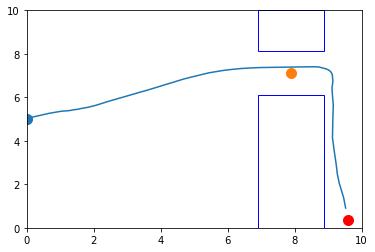

0
-0.43298140414951514
-0.11210504101808415
-0.19640056293523395
0.013588738172083885
-0.08216542542355024
-0.07215963417674974
-0.27516452325885465
-0.5620990862194263
0.03255968460934322
-0.25078468741375237
-0.12769377095171217


KeyboardInterrupt: 

In [35]:
dist1_list = []
dist2_list = []
dist3_list = []
rl_iteration_list = []
error_counter = 0
for step in range(0,1000):
    hole_x = np.random.uniform(2,8)
    hole_y = np.random.uniform(1,9)
    goal_x = np.random.uniform(hole_x+1.5,10)
    goal_y = np.random.uniform(0,10)

    new_X = np.zeros((1,time_N,5))

    for j in range(time_N):
        new_X[0,j,0]=times[j]
        new_X[0,j,1]=hole_x/10
        new_X[0,j,2]=hole_y/10
        new_X[0,j,3]=goal_x/10
        new_X[0,j,4]=goal_y/10

    new_observation = np.zeros((1,1,d_x+d_y))

    new_observation[0,0,:d_x] = new_X[0,199]
    new_observation[0,0,d_x:d_x+d_y] = np.array([goal_x,goal_y])
    
    prediction = model.predict([new_observation,new_X])[0]
    predicted_Y = prediction[:,:d_y]
    
    model.save('networks/acnmp{:d}.h5'.format(step))
    
    dist1=np.sqrt(np.square(predicted_Y[0,0]-0)+ np.square(predicted_Y[0,1]-5))

    dist2=10000
    for z in range(time_N):
        if (predicted_Y[z,0]>hole_x-1) and (predicted_Y[z,0]<hole_x+1):
            temp2=min(np.square(predicted_Y[z,1]-(hole_y-1)),np.square(predicted_Y[z,1]-(hole_y+1)))
            if (predicted_Y[z,1] > (hole_y+1)) or (predicted_Y[z,1] < (hole_y-1)):
                temp2 = temp2 * (-1)
        else:
            continue
        dist2=min(dist2,temp2)


    dist3=np.sqrt(np.square(predicted_Y[199,0]-goal_x)+ np.square(predicted_Y[199,1]-goal_y))

    dist=dist1+dist3
    dist1_list.append(dist1)
    dist2_list.append(dist2)
    dist3_list.append(dist3)
    
    target_states = new_X.reshape(200,1,5)
    
    

    if(dist1>0.15) or (dist3>0.15) or (dist2<0.2):
        error_counter = error_counter+1
        print(dist)
        print("error")
        new_trajectory, it_num = rl_learning(new_observation,target_states,hole_x,hole_y,goal_x,goal_y,new_X)
        rl_iteration_list.append(it_num)
        plot_figure(start_x,start_y,hole_x,hole_y,goal_x,goal_y,new_trajectory)
        adding_y = new_trajectory.reshape(1,200,2)
        Y=np.concatenate((Y,adding_y),axis=0 )
        X=np.concatenate((X,new_X),axis=0)
        d_N = d_N+1
        data_size = data_size +1

        max_training_step = 50000
        model.fit_generator(generator(), steps_per_epoch=max_training_step, epochs=1, verbose=1, callbacks=[CNMP_Callback()])
        model.load_weights('cnmp_best_validation_third_experiment.h5')


In [177]:
print(error_counter)
print(np.shape(dist1_list))
print(max(rl_iteration_list))
print(np.mean(rl_iteration_list))

311
(1000,)
727
57.31818181818182


## Trained model is loaded

In [15]:
model.load_weights('networks/acnmp{:d}.h5'.format(999))

## Animation is produced for random task parameters

<IPython.core.display.Javascript object>


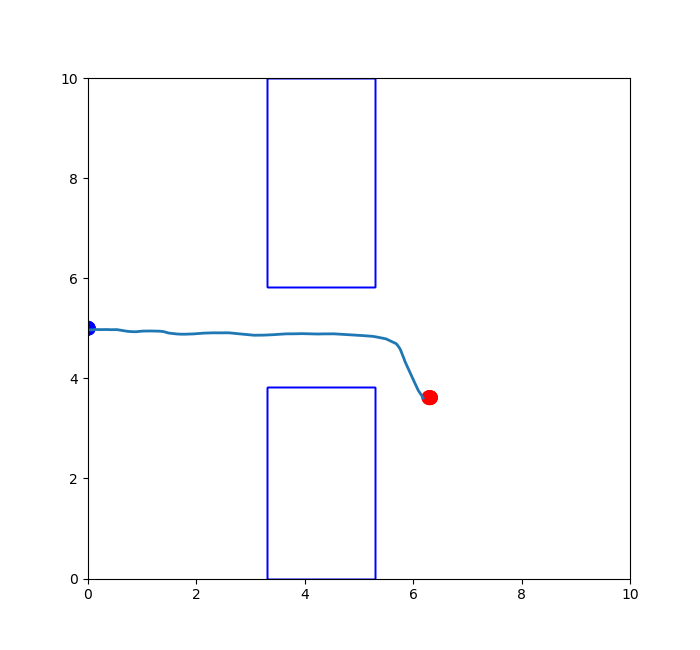

In [16]:
import matplotlib.animation as animation
%matplotlib notebook



dwx,dwy,dgx,dgy = 0.1,0.1,0.1,0.1

fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(7, 6.5)

ax = plt.axes(xlim=(0, 10), ylim=(0, 10))

hole_x = np.random.uniform(2,8)
hole_y = np.random.uniform(1,9)
goal_x = np.random.uniform(hole_x+1.5,10)
goal_y = np.random.uniform(0,10)
s_h_x=hole_x-1.3
e_h_x=hole_x+1.3
start_x = 0.0
start_y = 5.0

plt.scatter(start_x,start_y,s=10)

patch1 = plt.Rectangle((hole_x-1, 0), 
                    2, hole_y-1, 
                    fc ='none',  
                    ec ='b', 
                    lw = 1)

patch2 = plt.Rectangle((hole_x-1, hole_y+1), 
                            2, 9-hole_y, 
                            fc ='none',  
                            ec ='b', 
                            lw = 1)

c_patch1 = plt.Circle((0, 5), 0.15, fc='b')
c_patch2 = plt.Circle((goal_x, goal_y), 0.15, fc='r')

line, = ax.plot([], [], lw=2)

def init():
    
    ax.add_patch(patch1)
    ax.add_patch(patch2)
    ax.add_patch(c_patch1)
    ax.add_patch(c_patch2)

    line.set_data([], [])

    return patch1,patch2,c_patch1,c_patch2,line,

def animate(i):
    global hole_x,hole_y,goal_x,goal_y,dwx,dwy,dgx,dgy
    
    
    hole_x = hole_x + dwx
    goal_x = goal_x + dwx

    if goal_x < hole_x + 1.5 or goal_x > 10:
        goal_x = goal_x - dwx
        
    if hole_x < 2 or hole_x > 8:
        hole_x = hole_x - dwx
        dwx = -dwx

    hole_y = hole_y + dwy
    if hole_y < 1 or hole_y > 9:
        hole_y = hole_y - dwy
        dwy = -dwy


    goal_y = goal_y + dgy
    if goal_y < 0 or goal_y > 10:
        goal_y = goal_y - dgy
        dgy = -dgy
    
    
    start_x = 0.0
    start_y = 5.0
    patch1.xy = (hole_x-1, 0)
    patch1.set_width(2) 
    patch1.set_height(hole_y-1) 
    
    patch2.xy = (hole_x-1, hole_y+1)
    patch2.set_width(2)  
    patch2.set_height(9-hole_y)

    c_patch1.center=(0,5)
    c_patch2.center=(goal_x,goal_y)


    new_X = np.zeros((1,time_N,5))

    for j in range(time_N):
        new_X[0,j,0]=times[j]
        new_X[0,j,1]=hole_x/10
        new_X[0,j,2]=hole_y/10
        new_X[0,j,3]=goal_x/10
        new_X[0,j,4]=goal_y/10

    new_observation = np.zeros((1,1,d_x+d_y))


    new_observation[0,0,:d_x] = new_X[0,199]
    new_observation[0,0,d_x:d_x+d_y] = np.array([goal_x,goal_y])
    prediction = model.predict([new_observation,new_X])[0]
    predicted_Y = prediction[:,:d_y]

    line.set_data(predicted_Y[:,0], predicted_Y[:,1])
    
    
    return patch1,patch2,c_patch1,c_patch2,line,

anim = animation.FuncAnimation(fig, animate,
                               init_func=init,
                               frames=400,
                               interval=500,
                               blit=True)

from IPython.display import HTML
HTML(anim.to_jshtml())

anim.save('animation_trained_v1.mp4', fps=10,
          extra_args=['-vcodec', 'h264',
                      '-pix_fmt', 'yuv420p'])